# Train Model

In [1]:
import sys
import os

# Detect Google Colab
if "google.colab" in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Detect Google Colab
if "google.colab" in sys.modules:
    print("Running in Google Colab...")
    os.system("git clone https://github.com/CiaranMaloy/audioautoencoder")
    os.chdir("/content/audioautoencoder/")
    os.system("git pull")
    os.system("git checkout bandchannels")
    os.system("git pull origin bandchannels")
    #os.system("pip install --upgrade torchmetrics")
else:
    print("Running locally...")
    os.system("git pull origin bandchannels")
    #os.system("pip install --upgrade torchmetrics")


Running in Google Colab...


In [3]:
import sys
sys.path.append('/content/audioautoencoder')
sys.path.append('/content/audioautoencoder/audioautoencoder')

## Define Model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
import math

## Masking Unet
# enhanced attention on skip connections
# deep 3 headded self attention in bottleneck
class SinusoidalEmbeddings(nn.Module):
    def __init__(self, time_steps:int, embed_dim: int):
        super().__init__()
        position = torch.arange(time_steps).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        embeddings = torch.zeros(time_steps, embed_dim, requires_grad=False)
        embeddings[:, 0::2] = torch.sin(position * div)
        embeddings[:, 1::2] = torch.cos(position * div)
        self.embeddings = embeddings

    def forward(self, x, t):
        embeds = self.embeddings[t].to(x.device)
        return embeds[:, :, None, None]

class ResBlock(nn.Module):
    def __init__(self, channels:int, num_groups:int, dropout_prob:float, kernel_size=3):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.gnorm1 = nn.GroupNorm(num_groups=num_groups, num_channels=channels)
        self.gnorm2 = nn.GroupNorm(num_groups=num_groups, num_channels=channels)

        # Adding proper padding calculation to maintain spatial dimensions
        padding = kernel_size // 2 if isinstance(kernel_size, int) else (kernel_size[0] // 2, kernel_size[1] // 2)

        self.conv1 = nn.Conv2d(channels, channels, kernel_size=kernel_size, padding=padding)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=kernel_size, padding=padding)
        self.dropout = nn.Dropout(p=dropout_prob, inplace=True)

    def forward(self, x, embeddings):
        x = x + embeddings[:, :x.shape[1], :, :]
        r = self.conv1(self.relu(self.gnorm1(x)))
        r = self.dropout(r)
        r = self.conv2(self.relu(self.gnorm2(r)))  # Fixed: use r instead of x for the second conv
        return r + x

class Attention(nn.Module):
    def __init__(self, channels: int, num_heads:int , dropout_prob: float):
        super().__init__()
        self.proj1 = nn.Linear(channels, channels*3)
        self.proj2 = nn.Linear(channels, channels)
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob

    def forward(self, x):
        h, w = x.shape[2:]
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = self.proj1(x)
        x = rearrange(x, 'b L (C H K) -> K b H L C', K=3, H=self.num_heads)
        q,k,v = x[0], x[1], x[2]
        x = F.scaled_dot_product_attention(q,k,v, is_causal=False, dropout_p=self.dropout_prob)
        x = rearrange(x, 'b H (h w) C -> b h w (C H)', h=h, w=w)
        x = self.proj2(x)
        return rearrange(x, 'b h w C -> b C h w')

class LongformerAttention(nn.Module):
    def __init__(self, channels: int, num_heads: int, dropout_prob: float, window_size: int = 1025, global_tokens: int = 512):
        """
        Longformer attention that uses a sliding window + global attention mechanism.

        Args:
            channels: Input channel dimension
            num_heads: Number of attention heads
            dropout_prob: Dropout probability
            window_size: Size of the local attention window
            global_tokens: Number of global tokens to use (typically corners or other important positions)
        """
        super().__init__()
        self.proj1 = nn.Linear(channels, channels * 3)
        self.proj2 = nn.Linear(channels, channels)
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob
        self.window_size = window_size
        self.global_tokens = global_tokens
        self.head_dim = channels // num_heads

    def forward(self, x):
        h, w = x.shape[2:]
        seq_len = h * w
        batch_size = x.shape[0]

        # Reshape to sequence format
        x = rearrange(x, 'b c h w -> b (h w) c')

        # Project to query, key, value
        x = self.proj1(x)
        x = rearrange(x, 'b L (C H K) -> K b H L C', K=3, H=self.num_heads)
        q, k, v = x[0], x[1], x[2]

        # Create attention mask for sliding window
        # Start with a mask that allows local attention within the window
        mask = torch.zeros(seq_len, seq_len, device=x.device)

        # Fill in the local attention windows
        for i in range(seq_len):
            start = max(0, i - self.window_size // 2)
            end = min(seq_len, i + self.window_size // 2 + 1)
            mask[i, start:end] = 1

        # Add global attention tokens (e.g., corners of the image)
        # For simplicity, we'll use the first `global_tokens` positions
        if self.global_tokens > 0:
            global_indices = [0, w-1, seq_len-w, seq_len-1][:self.global_tokens]  # Corners

            # Global tokens attend to all positions
            for idx in global_indices:
                mask[idx, :] = 1
                mask[:, idx] = 1

        # Convert mask to attention mask format (0 for attended positions, -inf for masked positions)
        attn_mask = torch.zeros_like(mask)
        attn_mask[mask == 0] = float('-inf')

        # Compute attention with the mask
        scale = math.sqrt(self.head_dim)
        attn = torch.matmul(q, k.transpose(-2, -1)) / scale

        # Apply the attention mask
        attn = attn + attn_mask.unsqueeze(0).unsqueeze(0)

        attn = F.softmax(attn, dim=-1)
        attn = F.dropout(attn, p=self.dropout_prob, training=self.training)

        # Apply attention to values
        x = torch.matmul(attn, v)

        # Reshape back to original format
        x = rearrange(x, 'b H (h w) C -> b h w (C H)', h=h, w=w)
        x = self.proj2(x)
        return rearrange(x, 'b h w C -> b C h w')

class ResLayer(nn.Module):
    def __init__(self,
                 channels,
                 kernel_size=3,
                 attention=False,
                 long_attention=False,
                 lin_attention=False,
                 num_groups=16,
                 dropout_prob=0.1,
                 num_heads=8,
                 upscale=False,
                 downscale=False):
        super().__init__()
        self.upscale = upscale
        self.downscale = downscale

        # Calculate proper padding
        padding = kernel_size // 2 if isinstance(kernel_size, int) else (kernel_size[0] // 2, kernel_size[1] // 2)

        self.ResBlock1 = ResBlock(channels=channels, kernel_size=kernel_size, num_groups=num_groups, dropout_prob=dropout_prob)
        self.ResBlock2 = ResBlock(channels=channels, kernel_size=kernel_size, num_groups=num_groups, dropout_prob=dropout_prob)

        if upscale:
            self.conv = nn.ConvTranspose2d(channels, channels // 2, kernel_size=2, stride=2, padding=0)
        elif downscale:
            self.conv = nn.Conv2d(channels, channels * 2, kernel_size=3, stride=2, padding=1)

        if attention:
            self.attention_layer = Attention(channels, num_heads=num_heads, dropout_prob=dropout_prob)
        if long_attention:
            self.attention_layer = LongformerAttention(channels, num_heads=num_heads, dropout_prob=dropout_prob)

    def forward(self, x, embeddings):
        x = self.ResBlock1(x, embeddings)
        if hasattr(self, 'attention_layer'):
            x = self.attention_layer(x)
        x = self.ResBlock2(x, embeddings)

        if self.upscale:
            x = self.conv(x)
        elif self.downscale:
            x = self.conv(x)

        return x

class EnhancedSkipAttention(nn.Module):
    def __init__(self, encoder_channels, decoder_channels, reduction_ratio=4):
        super().__init__()
        self.channels = encoder_channels

        # Channel attention for encoder features
        self.encoder_channel_attn = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(encoder_channels, encoder_channels // reduction_ratio, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(encoder_channels // reduction_ratio, encoder_channels, kernel_size=1),
            nn.Sigmoid()
        )

        # Projection for decoder features to match encoder dimensions if needed
        self.decoder_proj = None
        if encoder_channels != decoder_channels:
            self.decoder_proj = nn.Conv2d(decoder_channels, encoder_channels, kernel_size=1)

        # Cross-attention between encoder and decoder features
        self.cross_attn = nn.Sequential(
            nn.Conv2d(encoder_channels*2, 2, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, encoder_features, decoder_features):
        # Process decoder features if dimensions don't match
        if self.decoder_proj is not None:
            decoder_features = self.decoder_proj(decoder_features)

        # Apply channel attention to encoder features
        channel_attn = self.encoder_channel_attn(encoder_features)
        encoder_features = encoder_features * channel_attn

        # Concatenate encoder and decoder features
        combined = torch.cat([encoder_features, decoder_features], dim=1)

        # Generate attention weights for each feature set
        attn_weights = self.cross_attn(combined)
        encoder_weight, decoder_weight = torch.split(attn_weights, 1, dim=1)

        # Apply weights and combine features
        result = encoder_features * encoder_weight + decoder_features * decoder_weight

        return result

class UNetConv11(nn.Module):
    # Update from UnetConv6, moving to a masking model, which hopefully works better
    def __init__(self, in_channels=4, out_channels=4, time_steps=1000):
        super().__init__()

        channels = 16

        # Fixed input layer with proper padding calculation for given kernel size
        self.sigmoid = nn.Sigmoid()
        self.input_layer = nn.Sequential(
            nn.Conv2d(in_channels, channels, kernel_size=(20, 10), padding=1, stride=2),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(channels, channels, kernel_size=(10, 5), padding=1),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Encoder (Downsampling) - using standard kernel sizes with proper padding
        self.enc1 = ResLayer(channels, kernel_size=7, downscale=True)
        self.enc2 = ResLayer(channels * 2, kernel_size=5, downscale=True)
        self.enc3 = ResLayer(channels * 4, kernel_size=3, downscale=True, attention=True)
        self.enc4 = ResLayer(channels * 8, kernel_size=3, downscale=True)

        # Bottleneck
        self.bottleneck_in = ResLayer(channels * 16, kernel_size=3)
        self.resattention = ResLayer(channels * 16, kernel_size=3, attention=True)
        self.bottleneck_out = ResLayer(channels * 16, kernel_size=3)

        # Decoder (Upsampling) - using standard kernel sizes
        self.dec4 = ResLayer(channels * 16, kernel_size=3, upscale=True)
        self.dec3 = ResLayer(channels * 8, kernel_size=3, upscale=True, attention=True)
        self.dec2 = ResLayer(channels * 4, kernel_size=5, upscale=True)
        self.dec1 = ResLayer(channels * 2, kernel_size=7, upscale=True)

        # Final output layer
        self.output_layer = nn.Sequential(
            nn.ConvTranspose2d(channels, out_channels, kernel_size=(10, 5), padding=1, stride=2),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Initialize Spatial Attention Modules
        self.attn4 = EnhancedSkipAttention(channels * 16, channels * 16)
        self.attn3 = EnhancedSkipAttention(channels * 8, channels * 8)
        self.attn2 = EnhancedSkipAttention(channels * 4, channels * 4)
        self.attn1 = EnhancedSkipAttention(channels * 2, channels * 2)

        # embeddings
        self.embeddings = SinusoidalEmbeddings(time_steps=time_steps, embed_dim=channels * 16)

    def forward(self, x, t=0):
        """Forward pass with skip connections"""
        input_shape = x.shape[2:]  # Remember original input spatial dimensions
        embeddings = self.embeddings(x, t)

        # Encoding
        input_features = self.input_layer(x)
        e1 = self.enc1(input_features, embeddings)
        e2 = self.enc2(e1, embeddings)
        e3 = self.enc3(e2, embeddings)
        e4 = self.enc4(e3, embeddings)

        # Bottleneck
        b = self.bottleneck_in(e4, embeddings)
        b = self.resattention(b, embeddings)
        b = self.bottleneck_out(b, embeddings)

        # Decoding with proper feature alignment
        # For decoder stage 4
        b = F.interpolate(b, size=e4.shape[2:], mode="bilinear", align_corners=False)
        d4 = self.attn4(e4, b)
        d4 = self.dec4(d4, embeddings)

        # For decoder stage 3
        d4 = F.interpolate(d4, size=e3.shape[2:], mode="bilinear", align_corners=False)
        d3 = self.attn3(e3, d4)
        d3 = self.dec3(d3, embeddings)

        # For decoder stage 2
        d3 = F.interpolate(d3, size=e2.shape[2:], mode="bilinear", align_corners=False)
        d2 = self.attn2(e2, d3)
        d2 = self.dec2(d2, embeddings)

        # For decoder stage 1
        d2 = F.interpolate(d2, size=e1.shape[2:], mode="bilinear", align_corners=False)
        d1 = self.attn1(e1, d2)
        d1 = self.dec1(d1, embeddings)

        # Final output with bilinear interpolation to match input size
        mask = self.output_layer(d1)
        mask = F.interpolate(mask, size=input_shape, mode="bilinear", align_corners=False)

        # Apply mask to the first 4 channels of input
        return mask

## Test Model

In [5]:
BATCH_SIZE = 1
t = torch.randint(0, 1000, (BATCH_SIZE,))
TEST_MODEL = True

if TEST_MODEL:
  if __name__ == "__main__":
      x = torch.randn((BATCH_SIZE, 4, 1025, 175))
      model = UNetConv11()
      output = model(x, t)

      print('output....')
      print(output.shape)

output....
torch.Size([1, 4, 1025, 175])


In [6]:
print(model)


UNetConv11(
  (sigmoid): Sigmoid()
  (input_layer): Sequential(
    (0): Conv2d(4, 16, kernel_size=(20, 10), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(16, 16, kernel_size=(10, 5), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (enc1): ResLayer(
    (ResBlock1): ResBlock(
      (relu): ReLU(inplace=True)
      (gnorm1): GroupNorm(16, 16, eps=1e-05, affine=True)
      (gnorm2): GroupNorm(16, 16, eps=1e-05, affine=True)
      (conv1): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (conv2): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (dropout): Dropout(p=0.1, inplace=True)
    )
    (ResBlock2): ResBlock(
      (relu): ReLU(inplace=True)
      (gnorm1): GroupNorm(

## Define Params

In [7]:
from audioautoencoder.plotting import *
from audioautoencoder.datasets.utils import *
#from audioautoencoder.models.UNetConv10mask import *
# Instantiate the model, define loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetConv11().to(device)

print(device)

cuda


In [8]:
i = 0
train = True
LOAD_DATA = True
load_model = False

# --------------- Main Execution parameters ---------------
model_name = 'UNetConv11_diffusion'
train_diffusion = True
SNRdB_load = [10, 30]
SNRdBs = [[10, 30]] # SNR random range
load_trigger = [load_model]
load_file = 'Autoencodermodel_earlystopping.pth'
#load_file = 'Autoencodermodel_checkpoint.pth'

folder = ['sep_features', 'all-noise_features'][1] # sep

# parameters
learning_rates = [1e-3] # 1e-4 for re0training?, 1e-3 for training?

base_lr=1e-5
max_lr=learning_rates[i]
gamma=0.8

# data params
max_file_size_gb = 100
IMPORT_TRAIN_NOISY = train
batch_size = 16

# training params
load = load_trigger[i]
warm_start = False
epochs = 100
accumulation_steps = int(128/batch_size)

SNRdB = SNRdBs[i]
learning_rate = learning_rates[i]
eta_min = 1e-6

print('lr:', learning_rate)
print('SNRdB:', SNRdB)

lr: 0.001
SNRdB: [10, 30]


In [9]:
# --------------- In Loop Parameters --------------
output_path = f'/content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Denoising/Checkpoints_{model_name}_{SNRdB[0]}-{SNRdB[1]}/'
load_path = f'/content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Denoising/Checkpoints_{model_name}_{SNRdB_load[0]}-{SNRdB_load[1]}/{load_file}'

## Load Data

In [10]:
import os
import joblib  # or use pickle if you prefer

def save_scalers(scalers, save_path):
    """Save scalers to a file."""
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    joblib.dump(scalers, save_path)

def load_scalers(save_path):
    """Load scalers from a file."""
    return joblib.load(save_path)

In [11]:
from audioautoencoder.datasets.utils import *
from audioautoencoder.data import *
from audioautoencoder.data_management import *
from audioautoencoder.generate_dataset import *

In [12]:
# Define the source and destination file paths
if LOAD_DATA:
  scaler_file = output_path + "scalers.pkl"  # Static filename since it's unique per run
  source_folder = f"/content/drive/MyDrive/Datasets/Music-Noise/SNRdB_{folder}/SNRdB_{SNRdB[0]}-{SNRdB[1]}/"
  source_path = source_folder + "train/"
  destination_path = f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/train/"
  save_path = source_folder + "combined_000.h5"
  subset = False

  if IMPORT_TRAIN_NOISY:
    dataset_path = f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/train/combined_000.h5"
    if not os.path.exists(destination_path):
      combine_h5_files_features(source_path, destination_path, max_file_size_gb=max_file_size_gb)

    if os.path.exists(scaler_file):
        print("Loading existing scalers...")
        scalers = load_scalers(scaler_file)
    else:
        print("Training new scalers...")
        scalers = train_scalers_separation(dataset_path, sample_size=8000)
        save_scalers(scalers, scaler_file)

    print(scalers)

    train_loader = DiffusionDatasetLoader(
          dataset_path=dataset_path,
          scalers=scalers,
          output_time_length=175,
          channels=1,
          snr_db=SNRdB,
          subset=subset,
          batch_size=batch_size
      )

    print(f"Training set size: {len(train_loader.train_dataset)}")
    print(f"Validation set size: {len(train_loader.val_dataset)}")

Loading existing scalers...
{'input_features_spectrogram': StandardScaler(), 'input_features_edges': StandardScaler(), 'input_features_cepstrum': StandardScaler(), 'input_features_cepstrum_edges': StandardScaler(), 'target_features_spectrogram': StandardScaler()}
Dataset size: 28729
Training set size: 22983
Validation set size: 5746
Training set size: 22983
Validation set size: 5746


## Inspect Data

In [13]:
if LOAD_DATA:
  input, output, medatata = train_loader.train_dataset[200]
  print(input.shape)
  print(output.shape)

torch.Size([9, 1025, 175])
torch.Size([4, 1025, 175])


In [14]:
class DDPM_Scheduler():
    def __init__(self, num_time_steps: int=1000):
        #super().__init__()
        self.beta = np.linspace(1e-4, 0.02, num_time_steps)
        alpha = 1 - self.beta
        self.alpha = np.cumprod(alpha)

    def forward(self, t):
        return self.beta[t], self.alpha[t]

diffusion_scheduler = DDPM_Scheduler()

29.2805233001709
Min, Max:  -0.12424549542279965 2.318688001357553
Min, Max:  -0.1556126141591876 1.4467233227091292
Min, Max:  -0.18207793937838618 1.5165043359229269
Min, Max:  -0.2005477124919847 1.2425821279198872
Min, Max:  -0.17638876354421684 2.337610220560523
Min, Max:  -0.17290969871562226 1.8954616802733928
Min, Max:  -0.1952322221494511 1.8427093650013884
Min, Max:  -0.18627184919097378 1.950209681786796
Min, Max:  -0.1765709593338362 3.819689538961302
Min, Max:  -0.12424549542279965 2.320882049025827
Min, Max:  -0.1556126141591876 1.4480942534511316
Min, Max:  -0.18207793937838618 1.5179053217511131
Min, Max:  -0.2005477124919847 1.2438076458919702
Min, Max:  -0.5716422231341481 0.7389102227099404
Min, Max:  -0.5701191524474086 0.6679194933983531
Min, Max:  -0.2909676774950539 0.3346711863028145
Min, Max:  -0.10237839337524872 0.13555111144127188


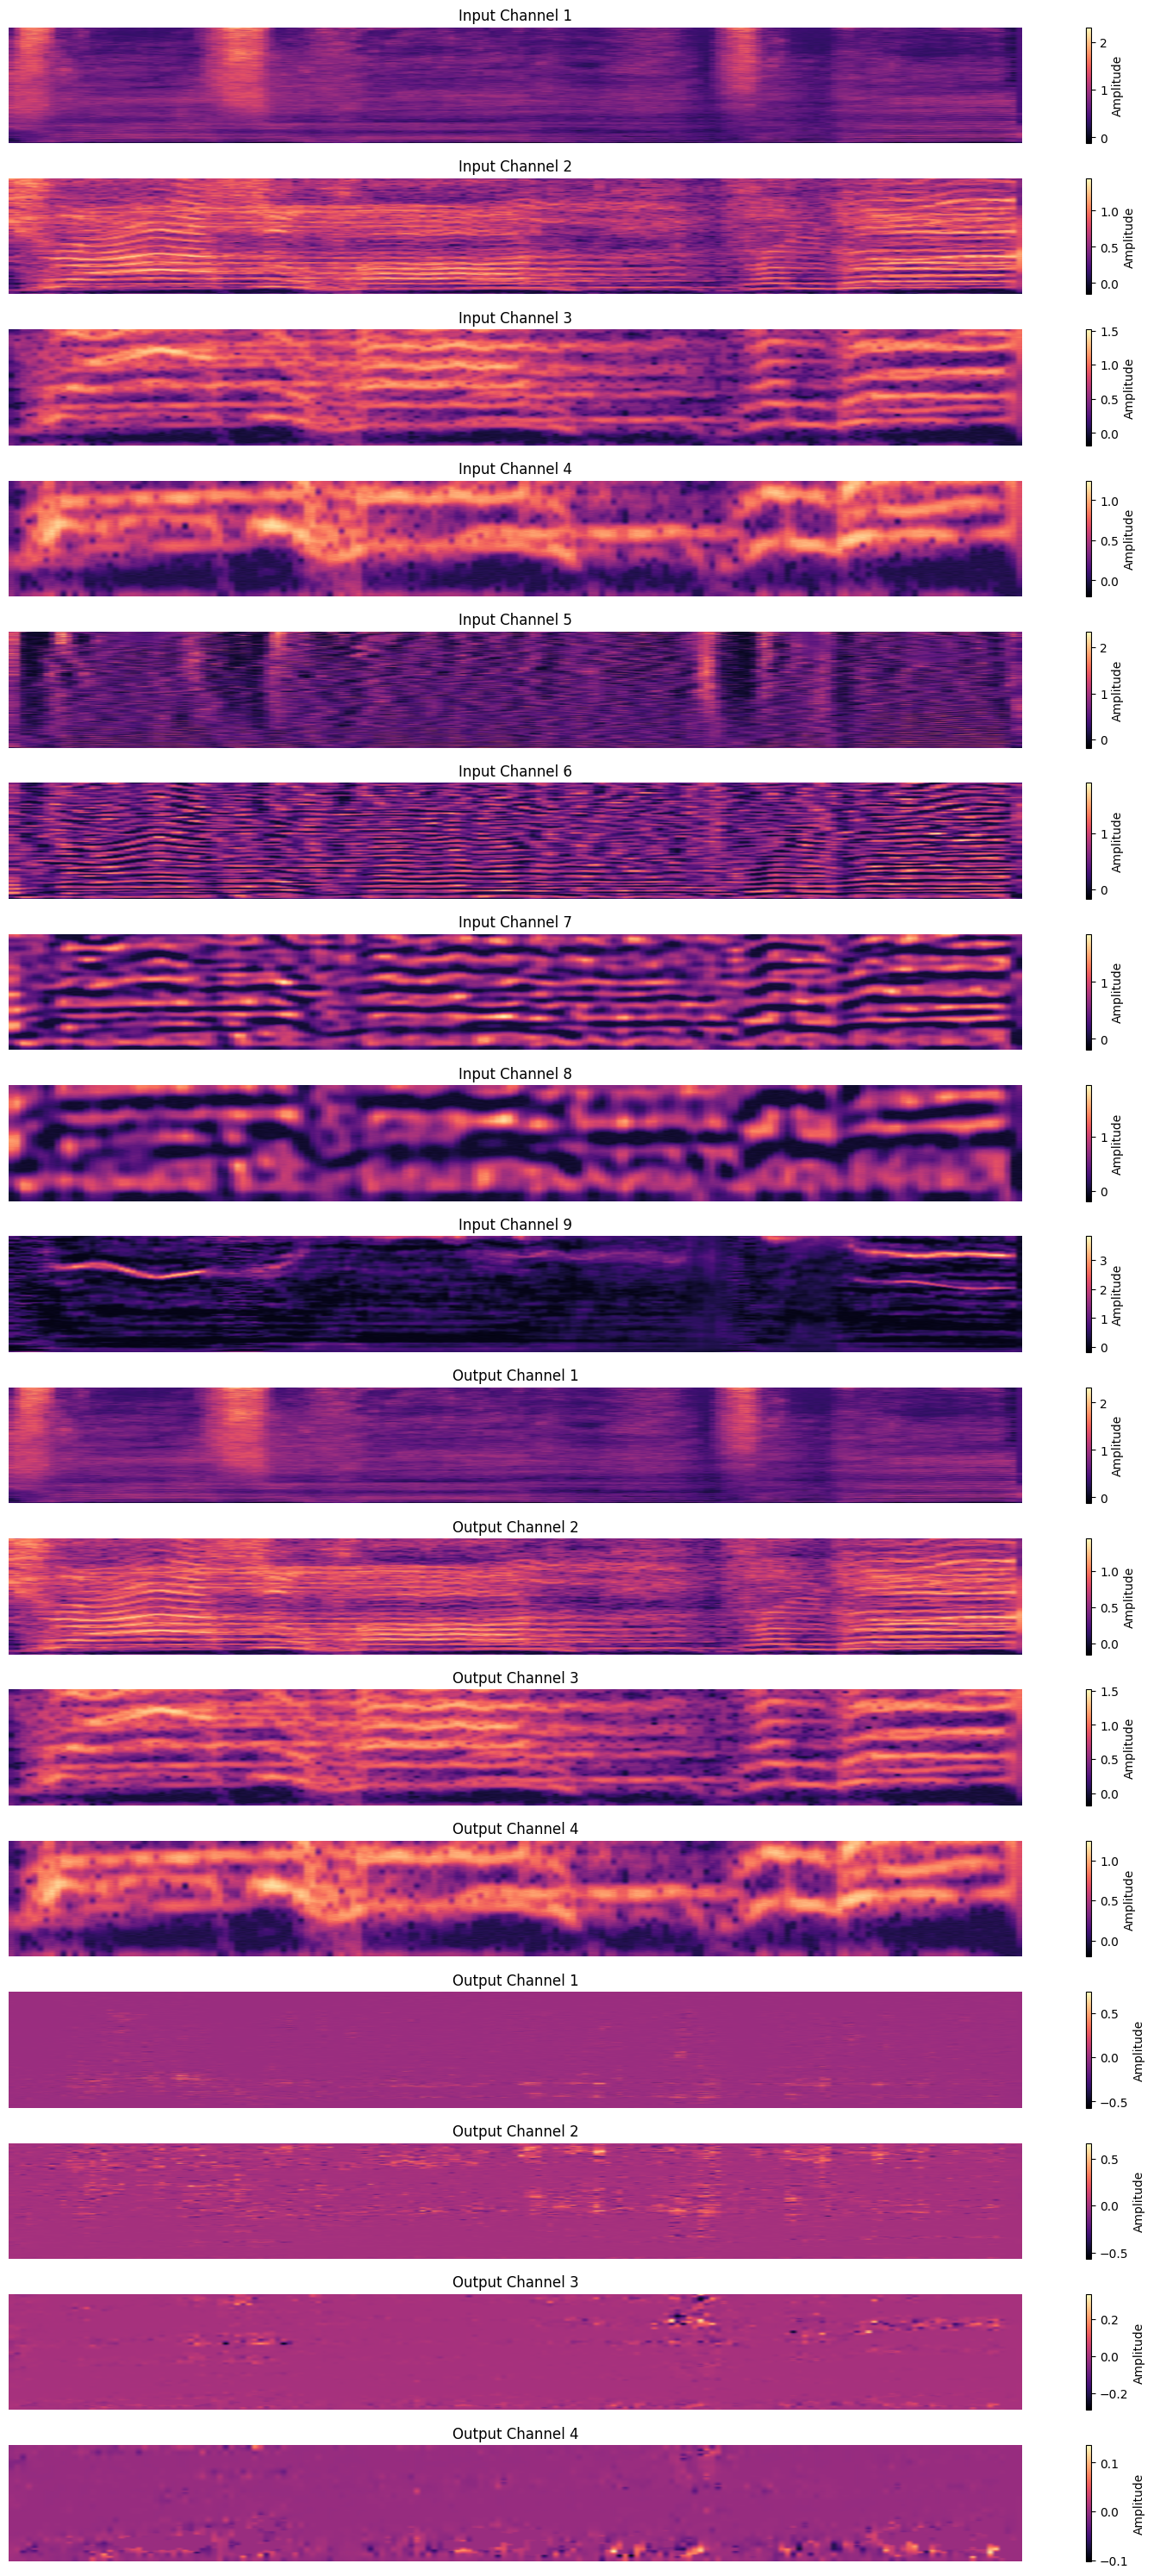

In [15]:
if LOAD_DATA:
  import matplotlib.pyplot as plt
  import torch
  import numpy as np
  import torch

  # Fetch a sample
  input_tensor, output_tensor, metadata = train_loader.train_dataset[51]

  print(metadata['snr_db'])

  # Convert to NumPy for plotting
  input_array = np.clip(input_tensor.numpy(), 0, a_max=None)
  output_array = np.clip(output_tensor.numpy(), 0, a_max=None)

  # remove negatve values
  #input_array = torch.clamp(input_array, min=0)  # Sets all negative values to 0

  # Get the actual batch size of the current batch
  actual_batch_size = 1
  num_time_steps = 1000

  # Assuming num_time_steps and actual_batch_size are defined
  t = 10#np.random.randint(0, num_time_steps, size=(actual_batch_size,))  # Sample t values
  e = np.random.randn(*input_array.shape)  # Gaussian noise

  # Get alpha values for sampled timesteps
  a = diffusion_scheduler.alpha[t].reshape(actual_batch_size, 1, 1, 1)  # Reshape for broadcasting

  # Apply forward diffusion step
  added_noise = (np.sqrt(1 - a) * e)
  input_array = (np.sqrt(a) * input_array) + added_noise

  # Number of input channels
  input_array = input_array[0]
  output_array = output_array + added_noise[0][0:4, :, :]
  num_channels_in = input_array.shape[0]
  num_channels_out = output_array.shape[0]

  difference = input_array[0:4, :, :] - output_array

  # Create subplots
  fig, axes = plt.subplots(num_channels_in + num_channels_out * 2, 1, figsize=(15, 30))

  # Plot each input channel
  for i in range(num_channels_in):
      input = input_array[i]
      print('Min, Max: ', np.min(input), np.max(input))
      im = axes[i].imshow(input, aspect='auto', cmap='magma')
      axes[i].invert_yaxis()

      axes[i].set_title(f"Input Channel {i+1}")
      axes[i].axis("off")

      # Add colorbar
      cbar = fig.colorbar(im, ax=axes[i], orientation="vertical")
      cbar.set_label("Amplitude")

    # Plot each input channel
  for i in range(num_channels_out):
      output = output_array[i]
      print('Min, Max: ', np.min(output), np.max(output))
      im = axes[num_channels_in + i].imshow(output, aspect='auto', cmap='magma')
      axes[num_channels_in + i].invert_yaxis()

      axes[num_channels_in + i].set_title(f"Output Channel {i+1}")
      axes[num_channels_in + i].axis("off")

      # Add colorbar
      cbar = fig.colorbar(im, ax=axes[num_channels_in + i], orientation="vertical")
      cbar.set_label("Amplitude")

  for i in range(num_channels_out):
      output = difference[i]
      print('Min, Max: ', np.min(output), np.max(output))
      im = axes[num_channels_in+num_channels_out + i].imshow(output, aspect='auto', cmap='magma')
      axes[num_channels_in+num_channels_out + i].invert_yaxis()

      axes[num_channels_in+num_channels_out + i].set_title(f"Output Channel {i+1}")
      axes[num_channels_in+num_channels_out + i].axis("off")

      # Add colorbar
      cbar = fig.colorbar(im, ax=axes[num_channels_in+num_channels_out + i], orientation="vertical")
      cbar.set_label("Amplitude")

  plt.tight_layout()
  plt.show()


## Train Model

In [16]:
from audioautoencoder.loss import *
from audioautoencoder.utils import *

In [17]:
import torch

torch.cuda.empty_cache()

In [18]:
if load:
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  #scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=eta_min)
  scheduler_loss = False
else:
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=eta_min)
  scheduler_loss = False

  #optimizer = None #torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  #scheduler = None #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
  #scheduler_loss = False #True

In [19]:
import torch
import gc

def clear_gpu_memory():
    """Clears all allocated GPU memory in PyTorch."""
    torch.cuda.empty_cache()  # Clears cache
    gc.collect()  # Runs Python garbage collector
    for i in range(torch.cuda.device_count()):
        torch.cuda.reset_peak_memory_stats(i)  # Resets peak memory tracking

clear_gpu_memory()

In [20]:
from audioautoencoder.training import *

In [21]:
if train:
  trainer = DenoisingTrainer(
      model=model, noisy_train_loader=train_loader.train_loader, noisy_val_loader=train_loader.val_loader,
      SNRdB=SNRdB, output_path=output_path, epochs=epochs, learning_rate=learning_rate,
      load=load, warm_start=warm_start, train=train, verbose=False, accumulation_steps=accumulation_steps, load_path=load_path,
      base_lr=base_lr, max_lr=max_lr, gamma=gamma, optimizer=optimizer, scheduler=scheduler, scheduler_loss=scheduler_loss,
      max_noise=0.00, noise_epochs=5, train_diffusion=train_diffusion
  )
  trainer.train_or_evaluate()
  model = trainer.get_model()

  # I need a flat load model function somewhere, as now I need to define a train loader before I can load a model
  csv_file_path = output_path + "training_log.csv"
  plot_training_log(csv_file_path)

Training on device: cuda
Epoch 1, Current Learning Rate: [0.001]


Training:   0%|          | 0/1437 [00:00<?, ?batch/s]

New kl loss beta: 0.0
Noise Level:  0.0
starting progress....


Epoch 1, Batch 0:   0%|          | 0/1437 [00:00<?, ?batch/s]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  0.1365242302417755
e:  -4.636055018636398e-05


Epoch 1, Batch 1:   0%|          | 2/1437 [00:02<32:02,  1.34s/batch, loss=loss: 1.0642, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  0.12457536906003952
e:  0.0001040189599734731


Epoch 1, Batch 2:   0%|          | 3/1437 [00:03<23:35,  1.01batch/s, loss=loss: 1.0695, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  0.15062637627124786
e:  0.00036653014831244946


Epoch 1, Batch 3:   0%|          | 4/1437 [00:04<19:19,  1.24batch/s, loss=loss: 1.0688, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  0.14217057824134827
e:  -5.253812560113147e-05


Epoch 1, Batch 4:   0%|          | 5/1437 [00:04<17:09,  1.39batch/s, loss=loss: 1.0689, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  0.14352837204933167
e:  0.00015953682304825634


Epoch 1, Batch 5:   0%|          | 6/1437 [00:05<15:36,  1.53batch/s, loss=loss: 1.0689, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  0.1358320713043213
e:  -0.0002682350459508598


Epoch 1, Batch 6:   0%|          | 7/1437 [00:05<14:44,  1.62batch/s, loss=loss: 1.0704, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  0.15718349814414978
e:  0.00016577489441260695


Epoch 1, Batch 7:   0%|          | 7/1437 [00:05<14:44,  1.62batch/s, loss=loss: 1.0704, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  0.14991983771324158
e:  0.00045977873378433287


Epoch 1, Batch 8:   1%|          | 9/1437 [00:06<13:35,  1.75batch/s, loss=loss: 1.0695, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  0.07850804924964905
e:  -0.0006399101112037897


Epoch 1, Batch 9:   1%|          | 10/1437 [00:07<13:18,  1.79batch/s, loss=loss: 1.0683, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  0.08237023651599884
e:  -0.0003202589869033545


Epoch 1, Batch 10:   1%|          | 11/1437 [00:07<13:03,  1.82batch/s, loss=loss: 1.0677, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  0.08360611647367477
e:  1.8987250314239645e-06


Epoch 1, Batch 11:   1%|          | 12/1437 [00:08<12:49,  1.85batch/s, loss=loss: 1.0670, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  0.0812164768576622
e:  -0.00028057576855644584


Epoch 1, Batch 12:   1%|          | 13/1437 [00:08<12:52,  1.84batch/s, loss=loss: 1.0660, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  0.0769912600517273
e:  4.502890078583732e-06


Epoch 1, Batch 13:   1%|          | 14/1437 [00:09<12:39,  1.87batch/s, loss=loss: 1.0648, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  0.0729231908917427
e:  2.806154589052312e-05


Epoch 1, Batch 14:   1%|          | 15/1437 [00:09<12:32,  1.89batch/s, loss=loss: 1.0645, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  0.08228247612714767
e:  0.0002042623091256246


Epoch 1, Batch 15:   1%|          | 16/1437 [00:10<12:26,  1.90batch/s, loss=loss: 1.0641, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  0.0801551416516304
e:  -0.00011967369209742174


Epoch 1, Batch 16:   1%|          | 17/1437 [00:10<12:17,  1.93batch/s, loss=loss: 1.0623, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  0.029612407088279724
e:  1.403360965923639e-05


Epoch 1, Batch 17:   1%|▏         | 18/1437 [00:11<12:03,  1.96batch/s, loss=loss: 1.0606, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  0.02786886878311634
e:  5.023346602683887e-05


Epoch 1, Batch 18:   1%|▏         | 19/1437 [00:11<12:02,  1.96batch/s, loss=loss: 1.0592, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  0.02477366290986538
e:  0.0003544146311469376


Epoch 1, Batch 19:   1%|▏         | 20/1437 [00:12<12:05,  1.95batch/s, loss=loss: 1.0577, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  0.02175207994878292
e:  4.601546606863849e-05


Epoch 1, Batch 20:   1%|▏         | 21/1437 [00:12<12:10,  1.94batch/s, loss=loss: 1.0564, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  0.02030806615948677
e:  -0.0001557456562295556


Epoch 1, Batch 21:   2%|▏         | 22/1437 [00:13<12:13,  1.93batch/s, loss=loss: 1.0552, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  0.024321774020791054
e:  -2.9409906346700154e-05


Epoch 1, Batch 22:   2%|▏         | 23/1437 [00:13<12:01,  1.96batch/s, loss=loss: 1.0543, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  0.029066789895296097
e:  -0.00019560742657631636


Epoch 1, Batch 23:   2%|▏         | 24/1437 [00:14<12:13,  1.93batch/s, loss=loss: 1.0532, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  0.022921526804566383
e:  0.00022536495816893876


Epoch 1, Batch 24:   2%|▏         | 25/1437 [00:15<12:11,  1.93batch/s, loss=loss: 1.0518, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.007428429089486599
e:  2.673457856872119e-05


Epoch 1, Batch 25:   2%|▏         | 26/1437 [00:15<12:14,  1.92batch/s, loss=loss: 1.0506, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.007426414173096418
e:  3.563165955711156e-05


Epoch 1, Batch 26:   2%|▏         | 27/1437 [00:16<12:15,  1.92batch/s, loss=loss: 1.0494, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.012869782745838165
e:  -4.0850212826626375e-05


Epoch 1, Batch 27:   2%|▏         | 28/1437 [00:16<12:20,  1.90batch/s, loss=loss: 1.0483, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.010040216147899628
e:  -0.00020583653531502932


Epoch 1, Batch 28:   2%|▏         | 29/1437 [00:17<12:17,  1.91batch/s, loss=loss: 1.0472, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.014349660836160183
e:  0.00038302643224596977


Epoch 1, Batch 29:   2%|▏         | 30/1437 [00:17<12:12,  1.92batch/s, loss=loss: 1.0463, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.011899009346961975
e:  -0.00020849921565968543


Epoch 1, Batch 30:   2%|▏         | 31/1437 [00:18<11:58,  1.96batch/s, loss=loss: 1.0455, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.016604742035269737
e:  -1.5869607523200102e-05


Epoch 1, Batch 31:   2%|▏         | 32/1437 [00:18<11:47,  1.98batch/s, loss=loss: 1.0446, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.01912858709692955
e:  -0.0005046637961640954


Epoch 1, Batch 32:   2%|▏         | 33/1437 [00:19<11:38,  2.01batch/s, loss=loss: 1.0437, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.038789018988609314
e:  -0.0003719209344126284


Epoch 1, Batch 33:   2%|▏         | 34/1437 [00:19<11:27,  2.04batch/s, loss=loss: 1.0428, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.04118546470999718
e:  -0.00022445085051003844


Epoch 1, Batch 34:   2%|▏         | 35/1437 [00:20<11:29,  2.03batch/s, loss=loss: 1.0421, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.04106497764587402
e:  -0.00017530794139020145


Epoch 1, Batch 35:   3%|▎         | 36/1437 [00:20<11:32,  2.02batch/s, loss=loss: 1.0413, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.044857900589704514
e:  2.7359263185644522e-05


Epoch 1, Batch 36:   3%|▎         | 37/1437 [00:21<11:36,  2.01batch/s, loss=loss: 1.0406, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.0480123907327652
e:  -0.00032518032821826637


Epoch 1, Batch 37:   3%|▎         | 38/1437 [00:21<11:37,  2.01batch/s, loss=loss: 1.0398, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.0432422049343586
e:  -0.00014176286640577018


Epoch 1, Batch 38:   3%|▎         | 39/1437 [00:22<11:37,  2.00batch/s, loss=loss: 1.0392, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.048088423907756805
e:  -0.00020176848920527846


Epoch 1, Batch 39:   3%|▎         | 40/1437 [00:22<11:29,  2.03batch/s, loss=loss: 1.0386, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.040894459933042526
e:  0.00030403921846300364


Epoch 1, Batch 40:   3%|▎         | 41/1437 [00:23<11:42,  1.99batch/s, loss=loss: 1.0379, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.055949386209249496
e:  -0.0002493225038051605


Epoch 1, Batch 41:   3%|▎         | 42/1437 [00:23<11:32,  2.01batch/s, loss=loss: 1.0374, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.06046576425433159
e:  -0.00022467302915174514


Epoch 1, Batch 42:   3%|▎         | 43/1437 [00:24<11:39,  1.99batch/s, loss=loss: 1.0368, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.05354535952210426
e:  0.00014421386003959924


Epoch 1, Batch 43:   3%|▎         | 44/1437 [00:24<11:30,  2.02batch/s, loss=loss: 1.0363, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.055259983986616135
e:  -0.00032634686795063317


Epoch 1, Batch 44:   3%|▎         | 45/1437 [00:25<11:23,  2.04batch/s, loss=loss: 1.0358, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.058875806629657745
e:  -0.00017077547090593725


Epoch 1, Batch 45:   3%|▎         | 46/1437 [00:25<11:21,  2.04batch/s, loss=loss: 1.0354, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.06125530228018761
e:  -0.0001577514922246337


Epoch 1, Batch 46:   3%|▎         | 47/1437 [00:26<11:12,  2.07batch/s, loss=loss: 1.0349, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.05858156085014343
e:  0.0006787126185372472


Epoch 1, Batch 47:   3%|▎         | 48/1437 [00:26<11:21,  2.04batch/s, loss=loss: 1.0344, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.057415809482336044
e:  6.79636013956042e-06


Epoch 1, Batch 48:   3%|▎         | 49/1437 [00:27<11:41,  1.98batch/s, loss=loss: 1.0340, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.05646226927638054
e:  -0.00011488203017506748


Epoch 1, Batch 49:   3%|▎         | 50/1437 [00:27<11:50,  1.95batch/s, loss=loss: 1.0336, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.05853711813688278
e:  0.0005184978363104165


Epoch 1, Batch 50:   4%|▎         | 51/1437 [00:28<11:54,  1.94batch/s, loss=loss: 1.0332, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.052747298032045364
e:  -0.00015552077093161643


Epoch 1, Batch 51:   4%|▎         | 52/1437 [00:28<12:06,  1.91batch/s, loss=loss: 1.0329, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.04715842753648758
e:  -0.00021966081112623215


Epoch 1, Batch 52:   4%|▎         | 53/1437 [00:29<12:01,  1.92batch/s, loss=loss: 1.0325, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.053137846291065216
e:  0.0002603371685836464


Epoch 1, Batch 53:   4%|▍         | 54/1437 [00:29<11:45,  1.96batch/s, loss=loss: 1.0322, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.05590292811393738
e:  0.00023068333393894136


Epoch 1, Batch 54:   4%|▍         | 55/1437 [00:30<11:52,  1.94batch/s, loss=loss: 1.0318, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.053144000470638275
e:  -0.00019316852558404207


Epoch 1, Batch 55:   4%|▍         | 56/1437 [00:30<11:41,  1.97batch/s, loss=loss: 1.0315, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.061492301523685455
e:  -0.0002654092386364937


Epoch 1, Batch 56:   4%|▍         | 57/1437 [00:31<11:39,  1.97batch/s, loss=loss: 1.0312, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.05072033777832985
e:  0.0004094426112715155


Epoch 1, Batch 57:   4%|▍         | 58/1437 [00:31<11:27,  2.01batch/s, loss=loss: 1.0309, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.052190348505973816
e:  0.0002934180374722928


Epoch 1, Batch 58:   4%|▍         | 59/1437 [00:32<11:28,  2.00batch/s, loss=loss: 1.0306, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.055045127868652344
e:  0.0002141175646102056


Epoch 1, Batch 59:   4%|▍         | 60/1437 [00:32<11:20,  2.02batch/s, loss=loss: 1.0303, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03850560635328293
e:  -0.0002075078518828377


Epoch 1, Batch 60:   4%|▍         | 61/1437 [00:33<11:14,  2.04batch/s, loss=loss: 1.0300, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.04175848886370659
e:  -0.000616648409049958


Epoch 1, Batch 61:   4%|▍         | 62/1437 [00:33<11:10,  2.05batch/s, loss=loss: 1.0297, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03786768391728401
e:  0.0008130828500725329


Epoch 1, Batch 62:   4%|▍         | 63/1437 [00:34<11:12,  2.04batch/s, loss=loss: 1.0295, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03394089639186859
e:  -1.4130266208667308e-05


Epoch 1, Batch 63:   4%|▍         | 64/1437 [00:34<11:18,  2.02batch/s, loss=loss: 1.0292, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03297463059425354
e:  0.0001746753987390548


Epoch 1, Batch 64:   5%|▍         | 65/1437 [00:35<11:18,  2.02batch/s, loss=loss: 1.0290, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.0509309247136116
e:  8.273823914350942e-05


Epoch 1, Batch 65:   5%|▍         | 66/1437 [00:35<11:31,  1.98batch/s, loss=loss: 1.0287, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.04684720188379288
e:  0.00010163521073991433


Epoch 1, Batch 66:   5%|▍         | 67/1437 [00:36<11:24,  2.00batch/s, loss=loss: 1.0284, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.061405207961797714
e:  6.502606993308291e-05


Epoch 1, Batch 67:   5%|▍         | 68/1437 [00:36<11:25,  2.00batch/s, loss=loss: 1.0282, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.031106475740671158
e:  0.0002399244549451396


Epoch 1, Batch 68:   5%|▍         | 69/1437 [00:37<11:19,  2.01batch/s, loss=loss: 1.0280, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03319566696882248
e:  -5.305701051838696e-05


Epoch 1, Batch 69:   5%|▍         | 70/1437 [00:37<11:24,  2.00batch/s, loss=loss: 1.0278, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03506223112344742
e:  0.00023526817676611245


Epoch 1, Batch 70:   5%|▍         | 71/1437 [00:38<11:22,  2.00batch/s, loss=loss: 1.0275, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.051269978284835815
e:  -0.00036289411946199834


Epoch 1, Batch 71:   5%|▌         | 72/1437 [00:38<11:23,  2.00batch/s, loss=loss: 1.0273, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.049024127423763275
e:  0.0003740247630048543


Epoch 1, Batch 72:   5%|▌         | 73/1437 [00:39<11:41,  1.95batch/s, loss=loss: 1.0271, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03939412906765938
e:  -0.0002266157534904778


Epoch 1, Batch 73:   5%|▌         | 74/1437 [00:39<11:43,  1.94batch/s, loss=loss: 1.0269, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.05030050501227379
e:  -0.00039373550680465996


Epoch 1, Batch 74:   5%|▌         | 75/1437 [00:40<11:56,  1.90batch/s, loss=loss: 1.0267, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.05034823715686798
e:  -0.0001236447860719636


Epoch 1, Batch 75:   5%|▌         | 76/1437 [00:40<11:57,  1.90batch/s, loss=loss: 1.0264, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.05032046511769295
e:  -0.000134328001877293


Epoch 1, Batch 76:   5%|▌         | 77/1437 [00:41<11:59,  1.89batch/s, loss=loss: 1.0262, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.037166424095630646
e:  0.0004319873405620456


Epoch 1, Batch 77:   5%|▌         | 78/1437 [00:41<11:33,  1.96batch/s, loss=loss: 1.0260, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.04574752226471901
e:  0.00015391728084068745


Epoch 1, Batch 78:   5%|▌         | 79/1437 [00:42<11:15,  2.01batch/s, loss=loss: 1.0258, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.05205175653100014
e:  0.0002642856852617115


Epoch 1, Batch 79:   6%|▌         | 80/1437 [00:42<11:05,  2.04batch/s, loss=loss: 1.0256, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.04647122696042061
e:  0.00018871774955186993


Epoch 1, Batch 80:   6%|▌         | 81/1437 [00:43<11:01,  2.05batch/s, loss=loss: 1.0255, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.05687307193875313
e:  -0.00010508602281333879


Epoch 1, Batch 81:   6%|▌         | 82/1437 [00:43<11:03,  2.04batch/s, loss=loss: 1.0253, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.043185096234083176
e:  3.593007204472087e-05


Epoch 1, Batch 82:   6%|▌         | 83/1437 [00:44<11:01,  2.05batch/s, loss=loss: 1.0251, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.04652715474367142
e:  -6.280119850998744e-05


Epoch 1, Batch 83:   6%|▌         | 84/1437 [00:44<11:01,  2.05batch/s, loss=loss: 1.0249, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.04339984059333801
e:  7.707804616075009e-05


Epoch 1, Batch 84:   6%|▌         | 85/1437 [00:45<10:53,  2.07batch/s, loss=loss: 1.0248, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.04551214352250099
e:  -0.00013566433335654438


Epoch 1, Batch 85:   6%|▌         | 86/1437 [00:45<10:45,  2.09batch/s, loss=loss: 1.0246, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.05054285004734993
e:  -0.0002328871632926166


Epoch 1, Batch 86:   6%|▌         | 87/1437 [00:46<10:55,  2.06batch/s, loss=loss: 1.0244, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.053554534912109375
e:  0.0001950132573256269


Epoch 1, Batch 87:   6%|▌         | 88/1437 [00:46<10:57,  2.05batch/s, loss=loss: 1.0243, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.04372148960828781
e:  -3.335460496600717e-05


Epoch 1, Batch 88:   6%|▌         | 89/1437 [00:47<10:55,  2.06batch/s, loss=loss: 1.0241, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.05191490054130554
e:  -9.489562216913328e-05


Epoch 1, Batch 89:   6%|▋         | 90/1437 [00:47<10:58,  2.05batch/s, loss=loss: 1.0240, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.04584089666604996
e:  0.00012186772801214829


Epoch 1, Batch 90:   6%|▋         | 91/1437 [00:48<11:11,  2.00batch/s, loss=loss: 1.0238, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.05516316369175911
e:  -2.584468893473968e-05


Epoch 1, Batch 91:   6%|▋         | 92/1437 [00:48<11:04,  2.02batch/s, loss=loss: 1.0236, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.04171306639909744
e:  0.0001708022755337879


Epoch 1, Batch 92:   6%|▋         | 93/1437 [00:49<10:58,  2.04batch/s, loss=loss: 1.0235, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.04234178364276886
e:  -0.0001179281753138639


Epoch 1, Batch 93:   7%|▋         | 94/1437 [00:49<10:52,  2.06batch/s, loss=loss: 1.0234, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.037112511694431305
e:  -1.541100391477812e-05


Epoch 1, Batch 94:   7%|▋         | 95/1437 [00:50<10:49,  2.07batch/s, loss=loss: 1.0232, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.04579686000943184
e:  -0.00013495332677848637


Epoch 1, Batch 95:   7%|▋         | 96/1437 [00:50<10:48,  2.07batch/s, loss=loss: 1.0231, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.05026402324438095
e:  -1.5496905689360574e-05


Epoch 1, Batch 96:   7%|▋         | 97/1437 [00:50<10:59,  2.03batch/s, loss=loss: 1.0229, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03400355949997902
e:  0.0002642917388584465


Epoch 1, Batch 97:   7%|▋         | 98/1437 [00:51<11:11,  1.99batch/s, loss=loss: 1.0228, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.04553946852684021
e:  0.0002301314234500751


Epoch 1, Batch 98:   7%|▋         | 99/1437 [00:52<11:31,  1.94batch/s, loss=loss: 1.0227, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03747674077749252
e:  8.537703979527578e-05


Epoch 1, Batch 99:   7%|▋         | 100/1437 [00:52<11:26,  1.95batch/s, loss=loss: 1.0225, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.049459390342235565
e:  -0.00038059140206314623


Epoch 1, Batch 100:   7%|▋         | 101/1437 [00:53<11:39,  1.91batch/s, loss=loss: 1.0224, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03481538966298103
e:  -1.549876105855219e-05


Epoch 1, Batch 101:   7%|▋         | 102/1437 [00:53<11:20,  1.96batch/s, loss=loss: 1.0223, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.043974995613098145
e:  -0.00020055397180840373


Epoch 1, Batch 102:   7%|▋         | 103/1437 [00:54<11:04,  2.01batch/s, loss=loss: 1.0221, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.04110125079751015
e:  0.0001324118347838521


Epoch 1, Batch 103:   7%|▋         | 104/1437 [00:54<10:58,  2.03batch/s, loss=loss: 1.0220, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.027519578114151955
e:  0.0003321970289107412


Epoch 1, Batch 104:   7%|▋         | 105/1437 [00:55<11:02,  2.01batch/s, loss=loss: 1.0219, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02795984223484993
e:  0.00016055602463893592


Epoch 1, Batch 105:   7%|▋         | 106/1437 [00:55<10:51,  2.04batch/s, loss=loss: 1.0218, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.04406949505209923
e:  -0.0002903469430748373


Epoch 1, Batch 106:   7%|▋         | 107/1437 [00:56<10:53,  2.04batch/s, loss=loss: 1.0217, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03950754925608635
e:  0.00011338709009578452


Epoch 1, Batch 107:   8%|▊         | 108/1437 [00:56<10:44,  2.06batch/s, loss=loss: 1.0216, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03874771669507027
e:  0.0002975163224618882


Epoch 1, Batch 108:   8%|▊         | 109/1437 [00:56<10:45,  2.06batch/s, loss=loss: 1.0214, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03347950056195259
e:  0.00010609802848193794


Epoch 1, Batch 109:   8%|▊         | 110/1437 [00:57<10:48,  2.05batch/s, loss=loss: 1.0213, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02939128689467907
e:  -0.00023729009262751788


Epoch 1, Batch 110:   8%|▊         | 111/1437 [00:57<10:46,  2.05batch/s, loss=loss: 1.0212, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.04721815139055252
e:  -0.0001646557793719694


Epoch 1, Batch 111:   8%|▊         | 112/1437 [00:58<10:44,  2.06batch/s, loss=loss: 1.0211, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.033415116369724274
e:  -2.401727033429779e-05


Epoch 1, Batch 112:   8%|▊         | 113/1437 [00:58<10:39,  2.07batch/s, loss=loss: 1.0210, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.0472797192633152
e:  0.0005330071435309947


Epoch 1, Batch 113:   8%|▊         | 114/1437 [00:59<10:43,  2.06batch/s, loss=loss: 1.0209, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03424544632434845
e:  0.0002073820651276037


Epoch 1, Batch 114:   8%|▊         | 115/1437 [00:59<10:46,  2.05batch/s, loss=loss: 1.0208, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.039856813848018646
e:  0.00011035233910661191


Epoch 1, Batch 115:   8%|▊         | 116/1437 [01:00<10:40,  2.06batch/s, loss=loss: 1.0207, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03972877562046051
e:  0.00035969543387182057


Epoch 1, Batch 116:   8%|▊         | 117/1437 [01:00<10:37,  2.07batch/s, loss=loss: 1.0206, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.04554245248436928
e:  0.00019672613416332752


Epoch 1, Batch 117:   8%|▊         | 118/1437 [01:01<10:37,  2.07batch/s, loss=loss: 1.0204, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.037557490170001984
e:  -3.696349813253619e-05


Epoch 1, Batch 118:   8%|▊         | 119/1437 [01:01<10:36,  2.07batch/s, loss=loss: 1.0203, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.028686901554465294
e:  0.0003406544274184853


Epoch 1, Batch 119:   8%|▊         | 120/1437 [01:02<10:48,  2.03batch/s, loss=loss: 1.0202, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03113573044538498
e:  0.00025837228167802095


Epoch 1, Batch 120:   8%|▊         | 121/1437 [01:02<10:40,  2.05batch/s, loss=loss: 1.0201, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.030099978670477867
e:  -0.00020208988280501217


Epoch 1, Batch 121:   8%|▊         | 122/1437 [01:03<10:38,  2.06batch/s, loss=loss: 1.0200, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.031345319002866745
e:  -0.0001277380797546357


Epoch 1, Batch 122:   9%|▊         | 123/1437 [01:03<10:56,  2.00batch/s, loss=loss: 1.0199, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02772969752550125
e:  2.5109267880907282e-05


Epoch 1, Batch 123:   9%|▊         | 124/1437 [01:04<11:15,  1.94batch/s, loss=loss: 1.0198, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03519163653254509
e:  0.00028827026835642755


Epoch 1, Batch 124:   9%|▊         | 125/1437 [01:04<11:17,  1.94batch/s, loss=loss: 1.0197, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02418462187051773
e:  0.00011144921882078052


Epoch 1, Batch 125:   9%|▉         | 126/1437 [01:05<11:36,  1.88batch/s, loss=loss: 1.0196, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03584102913737297
e:  -0.00014578724221792072


Epoch 1, Batch 126:   9%|▉         | 127/1437 [01:05<11:19,  1.93batch/s, loss=loss: 1.0195, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03860773146152496
e:  0.0002200309536419809


Epoch 1, Batch 127:   9%|▉         | 128/1437 [01:06<11:03,  1.97batch/s, loss=loss: 1.0194, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.027174117043614388
e:  7.478237967006862e-05


Epoch 1, Batch 128:   9%|▉         | 129/1437 [01:06<10:49,  2.01batch/s, loss=loss: 1.0193, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.021704308688640594
e:  0.0004828970995731652


Epoch 1, Batch 129:   9%|▉         | 130/1437 [01:07<10:45,  2.03batch/s, loss=loss: 1.0193, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.025488784536719322
e:  -0.00028798962011933327


Epoch 1, Batch 130:   9%|▉         | 131/1437 [01:07<10:34,  2.06batch/s, loss=loss: 1.0192, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.04071269929409027
e:  0.000199266301933676


Epoch 1, Batch 131:   9%|▉         | 132/1437 [01:08<10:39,  2.04batch/s, loss=loss: 1.0191, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03482301905751228
e:  -0.0003134812577627599


Epoch 1, Batch 132:   9%|▉         | 133/1437 [01:08<10:44,  2.02batch/s, loss=loss: 1.0190, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.04021449759602547
e:  0.0005478927050717175


Epoch 1, Batch 133:   9%|▉         | 134/1437 [01:09<10:42,  2.03batch/s, loss=loss: 1.0189, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.033228401094675064
e:  9.260330261895433e-05


Epoch 1, Batch 134:   9%|▉         | 135/1437 [01:09<10:39,  2.04batch/s, loss=loss: 1.0188, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.038424666970968246
e:  -0.00033054646337404847


Epoch 1, Batch 135:   9%|▉         | 136/1437 [01:10<12:17,  1.76batch/s, loss=loss: 1.0187, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.020659929141402245
e:  0.0002631432143971324


Epoch 1, Batch 136:  10%|▉         | 137/1437 [01:11<14:01,  1.55batch/s, loss=loss: 1.0187, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.024332474917173386
e:  -0.0002753531443886459


Epoch 1, Batch 137:  10%|▉         | 138/1437 [01:12<14:37,  1.48batch/s, loss=loss: 1.0186, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03852909058332443
e:  9.708111610962078e-05


Epoch 1, Batch 138:  10%|▉         | 139/1437 [01:12<14:55,  1.45batch/s, loss=loss: 1.0185, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.032755330204963684
e:  -0.0003443118475843221


Epoch 1, Batch 139:  10%|▉         | 140/1437 [01:13<15:40,  1.38batch/s, loss=loss: 1.0184, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.036166612058877945
e:  5.076979869045317e-05


Epoch 1, Batch 140:  10%|▉         | 141/1437 [01:14<15:43,  1.37batch/s, loss=loss: 1.0183, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02930985391139984
e:  -0.0003665073891170323


Epoch 1, Batch 141:  10%|▉         | 142/1437 [01:15<16:24,  1.32batch/s, loss=loss: 1.0182, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03509252890944481
e:  -0.0001848915999289602


Epoch 1, Batch 142:  10%|▉         | 143/1437 [01:16<16:55,  1.27batch/s, loss=loss: 1.0182, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.042470190674066544
e:  -0.00011546684254426509


Epoch 1, Batch 143:  10%|█         | 144/1437 [01:16<17:09,  1.26batch/s, loss=loss: 1.0181, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.037006501108407974
e:  0.0005454517086036503


Epoch 1, Batch 144:  10%|█         | 145/1437 [01:17<17:40,  1.22batch/s, loss=loss: 1.0180, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.033009123057127
e:  -0.0002443344856146723


Epoch 1, Batch 145:  10%|█         | 146/1437 [01:18<17:47,  1.21batch/s, loss=loss: 1.0179, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02867795340716839
e:  0.0003989739634562284


Epoch 1, Batch 146:  10%|█         | 147/1437 [01:19<17:16,  1.24batch/s, loss=loss: 1.0178, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03731706365942955
e:  -0.0004948333371430635


Epoch 1, Batch 147:  10%|█         | 148/1437 [01:20<17:25,  1.23batch/s, loss=loss: 1.0178, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03323180973529816
e:  -0.00016379141015931964


Epoch 1, Batch 148:  10%|█         | 149/1437 [01:21<17:09,  1.25batch/s, loss=loss: 1.0177, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.0465584397315979
e:  -0.000299740640912205


Epoch 1, Batch 149:  10%|█         | 150/1437 [01:21<17:15,  1.24batch/s, loss=loss: 1.0176, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.029584407806396484
e:  -9.355366637464613e-05


Epoch 1, Batch 150:  11%|█         | 151/1437 [01:22<16:59,  1.26batch/s, loss=loss: 1.0176, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.04022293537855148
e:  -0.0007640079711563885


Epoch 1, Batch 151:  11%|█         | 152/1437 [01:23<16:42,  1.28batch/s, loss=loss: 1.0175, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.04198252409696579
e:  -0.0003384905285201967


Epoch 1, Batch 152:  11%|█         | 153/1437 [01:24<17:15,  1.24batch/s, loss=loss: 1.0174, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.025651780888438225
e:  -0.00027326514828018844


Epoch 1, Batch 153:  11%|█         | 154/1437 [01:25<17:23,  1.23batch/s, loss=loss: 1.0173, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03240935876965523
e:  -9.920710726873949e-05


Epoch 1, Batch 154:  11%|█         | 155/1437 [01:25<17:36,  1.21batch/s, loss=loss: 1.0173, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.04280252754688263
e:  -4.023192741442472e-05


Epoch 1, Batch 155:  11%|█         | 156/1437 [01:26<17:58,  1.19batch/s, loss=loss: 1.0172, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03805141523480415
e:  -3.4386219340376556e-05


Epoch 1, Batch 156:  11%|█         | 157/1437 [01:27<17:55,  1.19batch/s, loss=loss: 1.0171, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.028354834765195847
e:  -0.00024549494264647365


Epoch 1, Batch 157:  11%|█         | 158/1437 [01:28<17:35,  1.21batch/s, loss=loss: 1.0171, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03925029933452606
e:  0.0001966663112398237


Epoch 1, Batch 158:  11%|█         | 159/1437 [01:29<17:38,  1.21batch/s, loss=loss: 1.0170, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.041638877242803574
e:  -0.0003610638959798962


Epoch 1, Batch 159:  11%|█         | 160/1437 [01:30<17:56,  1.19batch/s, loss=loss: 1.0169, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.041876427829265594
e:  -9.421155118616298e-05


Epoch 1, Batch 160:  11%|█         | 161/1437 [01:30<17:30,  1.22batch/s, loss=loss: 1.0168, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.031215080991387367
e:  -0.00018948447541333735


Epoch 1, Batch 161:  11%|█▏        | 162/1437 [01:31<17:42,  1.20batch/s, loss=loss: 1.0168, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.029473748058080673
e:  0.0004978612414561212


Epoch 1, Batch 162:  11%|█▏        | 163/1437 [01:32<17:21,  1.22batch/s, loss=loss: 1.0167, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.04046982154250145
e:  -0.0003317255468573421


Epoch 1, Batch 163:  11%|█▏        | 164/1437 [01:33<15:36,  1.36batch/s, loss=loss: 1.0167, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.04172798991203308
e:  -0.0003551481640897691


Epoch 1, Batch 164:  11%|█▏        | 165/1437 [01:33<13:53,  1.53batch/s, loss=loss: 1.0166, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.032283879816532135
e:  0.0001739393046591431


Epoch 1, Batch 165:  12%|█▏        | 166/1437 [01:34<12:50,  1.65batch/s, loss=loss: 1.0165, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03557797148823738
e:  3.8820464396849275e-05


Epoch 1, Batch 166:  12%|█▏        | 167/1437 [01:34<11:57,  1.77batch/s, loss=loss: 1.0165, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03844553977251053
e:  0.0005647675134241581


Epoch 1, Batch 167:  12%|█▏        | 168/1437 [01:34<11:24,  1.85batch/s, loss=loss: 1.0164, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.029889574274420738
e:  -0.00047526421258226037


Epoch 1, Batch 168:  12%|█▏        | 169/1437 [01:35<11:04,  1.91batch/s, loss=loss: 1.0163, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.0359773226082325
e:  1.967237585631665e-05


Epoch 1, Batch 169:  12%|█▏        | 170/1437 [01:35<11:08,  1.89batch/s, loss=loss: 1.0163, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02506100758910179
e:  -0.0005315231974236667


Epoch 1, Batch 170:  12%|█▏        | 171/1437 [01:36<10:54,  1.94batch/s, loss=loss: 1.0162, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.029702648520469666
e:  0.00014376603940036148


Epoch 1, Batch 171:  12%|█▏        | 172/1437 [01:36<10:35,  1.99batch/s, loss=loss: 1.0162, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.025939960032701492
e:  6.383944855770096e-05


Epoch 1, Batch 172:  12%|█▏        | 173/1437 [01:37<10:23,  2.03batch/s, loss=loss: 1.0161, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.030294816941022873
e:  -0.000511140504386276


Epoch 1, Batch 173:  12%|█▏        | 174/1437 [01:37<10:17,  2.04batch/s, loss=loss: 1.0160, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.023958105593919754
e:  -0.0003880738513544202


Epoch 1, Batch 174:  12%|█▏        | 175/1437 [01:38<10:21,  2.03batch/s, loss=loss: 1.0160, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.027857251465320587
e:  0.0004411934642121196


Epoch 1, Batch 175:  12%|█▏        | 176/1437 [01:38<10:19,  2.03batch/s, loss=loss: 1.0159, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.034022245556116104
e:  8.472649642499164e-05


Epoch 1, Batch 176:  12%|█▏        | 177/1437 [01:39<10:28,  2.00batch/s, loss=loss: 1.0159, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.0221596360206604
e:  0.0002823758404701948


Epoch 1, Batch 177:  12%|█▏        | 178/1437 [01:39<10:18,  2.04batch/s, loss=loss: 1.0158, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.026385299861431122
e:  -0.00022722978610545397


Epoch 1, Batch 178:  12%|█▏        | 179/1437 [01:40<10:24,  2.01batch/s, loss=loss: 1.0158, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.031444162130355835
e:  -0.00010936755279544741


Epoch 1, Batch 179:  13%|█▎        | 180/1437 [01:40<10:33,  1.99batch/s, loss=loss: 1.0157, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03527803346514702
e:  7.0188230893109e-05


Epoch 1, Batch 180:  13%|█▎        | 181/1437 [01:41<10:36,  1.97batch/s, loss=loss: 1.0156, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.031269919127225876
e:  0.0002346502587897703


Epoch 1, Batch 181:  13%|█▎        | 182/1437 [01:41<10:49,  1.93batch/s, loss=loss: 1.0156, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.033928532153367996
e:  -4.438320320332423e-05


Epoch 1, Batch 182:  13%|█▎        | 183/1437 [01:42<10:42,  1.95batch/s, loss=loss: 1.0155, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03464511036872864
e:  1.8361000911681913e-05


Epoch 1, Batch 183:  13%|█▎        | 184/1437 [01:42<10:29,  1.99batch/s, loss=loss: 1.0155, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.033939067274332047
e:  0.00011532980715855956


Epoch 1, Batch 184:  13%|█▎        | 185/1437 [01:43<10:20,  2.02batch/s, loss=loss: 1.0154, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02209731563925743
e:  3.1731782655697316e-05


Epoch 1, Batch 185:  13%|█▎        | 186/1437 [01:43<10:10,  2.05batch/s, loss=loss: 1.0154, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02026572823524475
e:  -5.5245003750314936e-05


Epoch 1, Batch 186:  13%|█▎        | 187/1437 [01:44<10:10,  2.05batch/s, loss=loss: 1.0153, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.023628702387213707
e:  0.00035989712341688573


Epoch 1, Batch 187:  13%|█▎        | 188/1437 [01:44<10:18,  2.02batch/s, loss=loss: 1.0153, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.027459565550088882
e:  0.00026527230511419475


Epoch 1, Batch 188:  13%|█▎        | 189/1437 [01:45<10:18,  2.02batch/s, loss=loss: 1.0152, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02396049164235592
e:  -0.00012928091746289283


Epoch 1, Batch 189:  13%|█▎        | 190/1437 [01:45<10:12,  2.04batch/s, loss=loss: 1.0152, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.019086897373199463
e:  0.00048187494394369423


Epoch 1, Batch 190:  13%|█▎        | 191/1437 [01:46<10:14,  2.03batch/s, loss=loss: 1.0151, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02825828269124031
e:  0.00021454556554090232


Epoch 1, Batch 191:  13%|█▎        | 192/1437 [01:46<10:16,  2.02batch/s, loss=loss: 1.0151, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.01905876025557518
e:  0.00042126074549742043


Epoch 1, Batch 192:  13%|█▎        | 193/1437 [01:47<10:12,  2.03batch/s, loss=loss: 1.0150, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02291438914835453
e:  -0.00031603503157384694


Epoch 1, Batch 193:  14%|█▎        | 194/1437 [01:47<10:24,  1.99batch/s, loss=loss: 1.0150, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.021522296592593193
e:  -0.0004106286505702883


Epoch 1, Batch 194:  14%|█▎        | 195/1437 [01:48<10:20,  2.00batch/s, loss=loss: 1.0149, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.028348712250590324
e:  -6.901453889440745e-05


Epoch 1, Batch 195:  14%|█▎        | 196/1437 [01:48<10:13,  2.02batch/s, loss=loss: 1.0149, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.013894917443394661
e:  2.4100900191115215e-05


Epoch 1, Batch 196:  14%|█▎        | 197/1437 [01:49<10:05,  2.05batch/s, loss=loss: 1.0148, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02276996709406376
e:  0.0002313874283572659


Epoch 1, Batch 197:  14%|█▍        | 198/1437 [01:49<10:10,  2.03batch/s, loss=loss: 1.0148, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.021202927455306053
e:  0.0003186489921063185


Epoch 1, Batch 198:  14%|█▍        | 199/1437 [01:50<10:17,  2.01batch/s, loss=loss: 1.0147, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.021104957908391953
e:  -0.00012368733587209135


Epoch 1, Batch 199:  14%|█▍        | 200/1437 [01:50<10:11,  2.02batch/s, loss=loss: 1.0147, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.0214210394769907
e:  -0.0004810453683603555


Epoch 1, Batch 200:  14%|█▍        | 201/1437 [01:51<10:09,  2.03batch/s, loss=loss: 1.0146, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.032096609473228455
e:  0.00041520060040056705


Epoch 1, Batch 201:  14%|█▍        | 202/1437 [01:51<10:07,  2.03batch/s, loss=loss: 1.0146, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.038137663155794144
e:  -0.00024092037347145379


Epoch 1, Batch 202:  14%|█▍        | 203/1437 [01:52<10:16,  2.00batch/s, loss=loss: 1.0146, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02276611328125
e:  -0.0002937020326498896


Epoch 1, Batch 203:  14%|█▍        | 204/1437 [01:52<10:21,  1.98batch/s, loss=loss: 1.0145, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.022553272545337677
e:  0.000400973716750741


Epoch 1, Batch 204:  14%|█▍        | 205/1437 [01:53<10:33,  1.95batch/s, loss=loss: 1.0145, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.026499804109334946
e:  -0.0002481522096786648


Epoch 1, Batch 205:  14%|█▍        | 206/1437 [01:53<10:41,  1.92batch/s, loss=loss: 1.0144, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.034503888338804245
e:  -3.3527026971569285e-05


Epoch 1, Batch 206:  14%|█▍        | 207/1437 [01:54<10:46,  1.90batch/s, loss=loss: 1.0144, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02786184661090374
e:  -0.00028801592998206615


Epoch 1, Batch 207:  14%|█▍        | 208/1437 [01:54<10:32,  1.94batch/s, loss=loss: 1.0143, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.026809070259332657
e:  0.0003489965747576207


Epoch 1, Batch 208:  15%|█▍        | 209/1437 [01:55<10:19,  1.98batch/s, loss=loss: 1.0143, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.027217993512749672
e:  -0.0001861314958659932


Epoch 1, Batch 209:  15%|█▍        | 210/1437 [01:55<10:06,  2.02batch/s, loss=loss: 1.0142, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02538912184536457
e:  0.0005170094664208591


Epoch 1, Batch 210:  15%|█▍        | 211/1437 [01:56<10:15,  1.99batch/s, loss=loss: 1.0142, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.029083209112286568
e:  0.00012011756916763261


Epoch 1, Batch 211:  15%|█▍        | 212/1437 [01:56<10:11,  2.00batch/s, loss=loss: 1.0141, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.032848041504621506
e:  -0.00015279419312719256


Epoch 1, Batch 212:  15%|█▍        | 213/1437 [01:57<10:04,  2.02batch/s, loss=loss: 1.0141, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02750837244093418
e:  -0.00022589598665945232


Epoch 1, Batch 213:  15%|█▍        | 214/1437 [01:57<09:55,  2.05batch/s, loss=loss: 1.0141, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.022364793345332146
e:  0.00029786539380438626


Epoch 1, Batch 214:  15%|█▍        | 215/1437 [01:58<09:50,  2.07batch/s, loss=loss: 1.0140, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.021321676671504974
e:  -0.00023964745923876762


Epoch 1, Batch 215:  15%|█▌        | 216/1437 [01:58<09:50,  2.07batch/s, loss=loss: 1.0140, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.0202497486025095
e:  -0.0001325570046901703


Epoch 1, Batch 216:  15%|█▌        | 217/1437 [01:59<09:45,  2.08batch/s, loss=loss: 1.0139, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02342825010418892
e:  0.00017502311675343663


Epoch 1, Batch 217:  15%|█▌        | 218/1437 [01:59<09:44,  2.09batch/s, loss=loss: 1.0139, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.030563632026314735
e:  7.315537368413061e-05


Epoch 1, Batch 218:  15%|█▌        | 219/1437 [02:00<09:42,  2.09batch/s, loss=loss: 1.0138, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.024939676746726036
e:  -0.000720671727322042


Epoch 1, Batch 219:  15%|█▌        | 220/1437 [02:00<09:42,  2.09batch/s, loss=loss: 1.0138, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03235072270035744
e:  -4.57787791674491e-05


Epoch 1, Batch 220:  15%|█▌        | 221/1437 [02:01<09:50,  2.06batch/s, loss=loss: 1.0138, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.0172074306756258
e:  0.0001625590812182054


Epoch 1, Batch 221:  15%|█▌        | 222/1437 [02:01<09:43,  2.08batch/s, loss=loss: 1.0137, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.026582790538668633
e:  -0.00080408452777192


Epoch 1, Batch 222:  16%|█▌        | 223/1437 [02:02<09:46,  2.07batch/s, loss=loss: 1.0137, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.028459232300519943
e:  -0.0004046653921250254


Epoch 1, Batch 223:  16%|█▌        | 224/1437 [02:02<09:47,  2.07batch/s, loss=loss: 1.0136, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.020627198740839958
e:  0.00036218712921254337


Epoch 1, Batch 224:  16%|█▌        | 225/1437 [02:03<09:42,  2.08batch/s, loss=loss: 1.0136, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.020038239657878876
e:  0.00034391938243061304


Epoch 1, Batch 225:  16%|█▌        | 226/1437 [02:03<09:49,  2.06batch/s, loss=loss: 1.0136, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02390105277299881
e:  -5.3357081924332306e-05


Epoch 1, Batch 226:  16%|█▌        | 227/1437 [02:04<10:00,  2.02batch/s, loss=loss: 1.0135, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.016271010041236877
e:  0.00018425140297040343


Epoch 1, Batch 227:  16%|█▌        | 228/1437 [02:04<10:11,  1.98batch/s, loss=loss: 1.0135, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02338981442153454
e:  -0.00013967191625852138


Epoch 1, Batch 228:  16%|█▌        | 229/1437 [02:05<10:22,  1.94batch/s, loss=loss: 1.0134, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.022773582488298416
e:  -0.00033658373286016285


Epoch 1, Batch 229:  16%|█▌        | 230/1437 [02:05<10:34,  1.90batch/s, loss=loss: 1.0134, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.01787562295794487
e:  -0.00014722385094501078


Epoch 1, Batch 230:  16%|█▌        | 231/1437 [02:06<10:36,  1.90batch/s, loss=loss: 1.0133, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.025075336918234825
e:  1.512690414529061e-05


Epoch 1, Batch 231:  16%|█▌        | 232/1437 [02:06<10:21,  1.94batch/s, loss=loss: 1.0133, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.01827879436314106
e:  -0.00024755089543759823


Epoch 1, Batch 232:  16%|█▌        | 233/1437 [02:07<10:08,  1.98batch/s, loss=loss: 1.0133, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.025730371475219727
e:  4.6477463911287487e-05


Epoch 1, Batch 233:  16%|█▋        | 234/1437 [02:07<10:02,  2.00batch/s, loss=loss: 1.0132, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02774709463119507
e:  -0.0002584291505627334


Epoch 1, Batch 234:  16%|█▋        | 235/1437 [02:08<09:55,  2.02batch/s, loss=loss: 1.0132, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03211845085024834
e:  0.00026523054111748934


Epoch 1, Batch 235:  16%|█▋        | 236/1437 [02:08<09:44,  2.05batch/s, loss=loss: 1.0132, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03177322447299957
e:  -3.4281129046576098e-06


Epoch 1, Batch 236:  16%|█▋        | 237/1437 [02:09<09:38,  2.08batch/s, loss=loss: 1.0131, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.021104736253619194
e:  6.353737262543291e-05


Epoch 1, Batch 237:  17%|█▋        | 238/1437 [02:09<09:40,  2.06batch/s, loss=loss: 1.0131, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.023083139210939407
e:  -0.0005096540553495288


Epoch 1, Batch 238:  17%|█▋        | 239/1437 [02:10<09:46,  2.04batch/s, loss=loss: 1.0131, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02163832262158394
e:  -9.293364564655349e-05


Epoch 1, Batch 239:  17%|█▋        | 240/1437 [02:10<09:46,  2.04batch/s, loss=loss: 1.0130, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.023461604490876198
e:  0.00033127330243587494


Epoch 1, Batch 240:  17%|█▋        | 241/1437 [02:11<09:34,  2.08batch/s, loss=loss: 1.0130, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.020592020824551582
e:  0.00012142617924837396


Epoch 1, Batch 241:  17%|█▋        | 242/1437 [02:11<09:38,  2.07batch/s, loss=loss: 1.0129, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.030075764283537865
e:  0.0002884090063162148


Epoch 1, Batch 242:  17%|█▋        | 243/1437 [02:12<09:32,  2.09batch/s, loss=loss: 1.0129, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.031073827296495438
e:  0.0002634123957250267


Epoch 1, Batch 243:  17%|█▋        | 244/1437 [02:12<09:32,  2.08batch/s, loss=loss: 1.0129, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.015107287093997002
e:  0.00011689586244756356


Epoch 1, Batch 244:  17%|█▋        | 245/1437 [02:13<09:34,  2.07batch/s, loss=loss: 1.0128, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.022707311436533928
e:  0.0007308467174880207


Epoch 1, Batch 245:  17%|█▋        | 246/1437 [02:13<09:29,  2.09batch/s, loss=loss: 1.0128, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02547699585556984
e:  0.0002730349078774452


Epoch 1, Batch 246:  17%|█▋        | 247/1437 [02:14<09:31,  2.08batch/s, loss=loss: 1.0128, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.019761957228183746
e:  1.3566605048254132e-05


Epoch 1, Batch 247:  17%|█▋        | 248/1437 [02:14<09:34,  2.07batch/s, loss=loss: 1.0127, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.019931796938180923
e:  7.815860044502188e-06


Epoch 1, Batch 248:  17%|█▋        | 249/1437 [02:14<09:34,  2.07batch/s, loss=loss: 1.0127, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.032507386058568954
e:  -0.00044912920566275716


Epoch 1, Batch 249:  17%|█▋        | 250/1437 [02:15<09:33,  2.07batch/s, loss=loss: 1.0127, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.025130700320005417
e:  0.00018278215429745615


Epoch 1, Batch 250:  17%|█▋        | 251/1437 [02:15<09:28,  2.09batch/s, loss=loss: 1.0126, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.0256475992500782
e:  -0.00040116271702572703


Epoch 1, Batch 251:  18%|█▊        | 252/1437 [02:16<09:29,  2.08batch/s, loss=loss: 1.0126, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.024398401379585266
e:  -9.497107384959236e-05


Epoch 1, Batch 252:  18%|█▊        | 253/1437 [02:16<09:39,  2.04batch/s, loss=loss: 1.0126, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.020997583866119385
e:  0.000378704397007823


Epoch 1, Batch 253:  18%|█▊        | 254/1437 [02:17<09:56,  1.98batch/s, loss=loss: 1.0125, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.021779287606477737
e:  -0.0005220189923420548


Epoch 1, Batch 254:  18%|█▊        | 255/1437 [02:17<09:58,  1.98batch/s, loss=loss: 1.0125, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.0306955948472023
e:  0.0001206367087434046


Epoch 1, Batch 255:  18%|█▊        | 256/1437 [02:18<10:13,  1.93batch/s, loss=loss: 1.0125, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.022723842412233353
e:  0.0001756725978339091


Epoch 1, Batch 256:  18%|█▊        | 257/1437 [02:19<10:07,  1.94batch/s, loss=loss: 1.0124, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.024785462766885757
e:  0.00033337154309265316


Epoch 1, Batch 257:  18%|█▊        | 258/1437 [02:19<10:08,  1.94batch/s, loss=loss: 1.0124, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02856946364045143
e:  0.00027365857386030257


Epoch 1, Batch 258:  18%|█▊        | 259/1437 [02:20<10:00,  1.96batch/s, loss=loss: 1.0124, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.028494136407971382
e:  -0.0006322651170194149


Epoch 1, Batch 259:  18%|█▊        | 260/1437 [02:20<09:51,  1.99batch/s, loss=loss: 1.0123, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03003009222447872
e:  0.00015087862266227603


Epoch 1, Batch 260:  18%|█▊        | 261/1437 [02:21<09:41,  2.02batch/s, loss=loss: 1.0123, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.029510125517845154
e:  -0.0005322094657458365


Epoch 1, Batch 261:  18%|█▊        | 262/1437 [02:21<09:39,  2.03batch/s, loss=loss: 1.0123, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.030001437291502953
e:  0.0007537237834185362


Epoch 1, Batch 262:  18%|█▊        | 263/1437 [02:22<09:39,  2.03batch/s, loss=loss: 1.0122, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.033453360199928284
e:  -0.0003912887186743319


Epoch 1, Batch 263:  18%|█▊        | 264/1437 [02:22<09:40,  2.02batch/s, loss=loss: 1.0122, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.026485947892069817
e:  0.0001773660769686103


Epoch 1, Batch 264:  18%|█▊        | 265/1437 [02:22<09:31,  2.05batch/s, loss=loss: 1.0122, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02286686562001705
e:  0.00011488890595501289


Epoch 1, Batch 265:  19%|█▊        | 266/1437 [02:23<09:26,  2.07batch/s, loss=loss: 1.0121, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03178317844867706
e:  -0.000381354708224535


Epoch 1, Batch 266:  19%|█▊        | 267/1437 [02:23<09:34,  2.04batch/s, loss=loss: 1.0121, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.021894505247473717
e:  0.0006338814273476601


Epoch 1, Batch 267:  19%|█▊        | 268/1437 [02:24<09:35,  2.03batch/s, loss=loss: 1.0121, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.024884315207600594
e:  -0.0004121199599467218


Epoch 1, Batch 268:  19%|█▊        | 269/1437 [02:24<09:36,  2.03batch/s, loss=loss: 1.0120, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.029982512816786766
e:  -0.00025827588979154825


Epoch 1, Batch 269:  19%|█▉        | 270/1437 [02:25<09:30,  2.05batch/s, loss=loss: 1.0120, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.023339280858635902
e:  0.00019073892326559871


Epoch 1, Batch 270:  19%|█▉        | 271/1437 [02:25<09:25,  2.06batch/s, loss=loss: 1.0120, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.029709361493587494
e:  0.00046761665726080537


Epoch 1, Batch 271:  19%|█▉        | 272/1437 [02:26<09:21,  2.08batch/s, loss=loss: 1.0120, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.03176526725292206
e:  -0.00022800362785346806


Epoch 1, Batch 272:  19%|█▉        | 273/1437 [02:26<09:17,  2.09batch/s, loss=loss: 1.0119, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.022945920005440712
e:  -0.0003005469625350088


Epoch 1, Batch 273:  19%|█▉        | 274/1437 [02:27<09:22,  2.07batch/s, loss=loss: 1.0119, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.022971944883465767
e:  0.00011094715591752902


Epoch 1, Batch 274:  19%|█▉        | 275/1437 [02:27<09:20,  2.07batch/s, loss=loss: 1.0119, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02856186032295227
e:  -0.00022904918296262622


Epoch 1, Batch 275:  19%|█▉        | 276/1437 [02:28<09:30,  2.04batch/s, loss=loss: 1.0118, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.023479823023080826
e:  -0.00012169017281848937


Epoch 1, Batch 276:  19%|█▉        | 277/1437 [02:28<09:26,  2.05batch/s, loss=loss: 1.0118, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02473462000489235
e:  -7.430750702042133e-05


Epoch 1, Batch 277:  19%|█▉        | 278/1437 [02:29<09:41,  1.99batch/s, loss=loss: 1.0118, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.026054956018924713
e:  0.0002886590373236686


Epoch 1, Batch 278:  19%|█▉        | 279/1437 [02:29<09:49,  1.96batch/s, loss=loss: 1.0117, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.027430551126599312
e:  -0.00035537764779292047


Epoch 1, Batch 279:  19%|█▉        | 280/1437 [02:30<10:01,  1.92batch/s, loss=loss: 1.0117, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.023398660123348236
e:  -0.0003609254490584135


Epoch 1, Batch 280:  20%|█▉        | 281/1437 [02:30<10:01,  1.92batch/s, loss=loss: 1.0117, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.025825180113315582
e:  0.00032160768751055


Epoch 1, Batch 281:  20%|█▉        | 282/1437 [02:31<10:00,  1.92batch/s, loss=loss: 1.0117, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.019213860854506493
e:  0.0001460328057873994


Epoch 1, Batch 282:  20%|█▉        | 283/1437 [02:31<09:47,  1.96batch/s, loss=loss: 1.0116, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.022549808025360107
e:  9.137480810750276e-05


Epoch 1, Batch 283:  20%|█▉        | 284/1437 [02:32<09:39,  1.99batch/s, loss=loss: 1.0116, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.022474467754364014
e:  8.425416308455169e-05


Epoch 1, Batch 284:  20%|█▉        | 285/1437 [02:32<09:27,  2.03batch/s, loss=loss: 1.0116, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02197558991611004
e:  0.00018024489691015333


Epoch 1, Batch 285:  20%|█▉        | 286/1437 [02:33<09:28,  2.02batch/s, loss=loss: 1.0115, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02009420096874237
e:  0.0002093424991471693


Epoch 1, Batch 286:  20%|█▉        | 287/1437 [02:33<09:21,  2.05batch/s, loss=loss: 1.0115, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02107888087630272
e:  0.0003476795391179621


Epoch 1, Batch 287:  20%|██        | 288/1437 [02:34<09:21,  2.05batch/s, loss=loss: 1.0115, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.014163232408463955
e:  -6.332748307613656e-05


Epoch 1, Batch 288:  20%|██        | 289/1437 [02:34<09:17,  2.06batch/s, loss=loss: 1.0115, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.025913262739777565
e:  -2.0391484213178046e-05


Epoch 1, Batch 289:  20%|██        | 290/1437 [02:35<09:18,  2.06batch/s, loss=loss: 1.0114, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.023615168407559395
e:  -0.0006466849008575082


Epoch 1, Batch 290:  20%|██        | 291/1437 [02:35<09:11,  2.08batch/s, loss=loss: 1.0114, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.023466750979423523
e:  -0.0005786592955701053


Epoch 1, Batch 291:  20%|██        | 292/1437 [02:36<09:14,  2.07batch/s, loss=loss: 1.0114, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.022070415318012238
e:  -0.00027702131774276495


Epoch 1, Batch 292:  20%|██        | 293/1437 [02:36<09:13,  2.07batch/s, loss=loss: 1.0113, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.018545955419540405
e:  2.296895399922505e-05


Epoch 1, Batch 293:  20%|██        | 294/1437 [02:37<09:09,  2.08batch/s, loss=loss: 1.0113, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.01777629181742668
e:  0.00016860748291946948


Epoch 1, Batch 294:  21%|██        | 295/1437 [02:37<09:08,  2.08batch/s, loss=loss: 1.0113, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.025275755673646927
e:  0.0002454701461829245


Epoch 1, Batch 295:  21%|██        | 296/1437 [02:38<09:08,  2.08batch/s, loss=loss: 1.0113, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02092725597321987
e:  3.042499338334892e-05


Epoch 1, Batch 296:  21%|██        | 297/1437 [02:38<09:03,  2.10batch/s, loss=loss: 1.0112, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.019990934059023857
e:  1.4630379155278206e-05


Epoch 1, Batch 297:  21%|██        | 298/1437 [02:39<09:01,  2.10batch/s, loss=loss: 1.0112, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.020363830029964447
e:  0.00034493362181819975


Epoch 1, Batch 298:  21%|██        | 299/1437 [02:39<09:04,  2.09batch/s, loss=loss: 1.0112, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.021313276141881943
e:  0.00016504251107107848


Epoch 1, Batch 299:  21%|██        | 300/1437 [02:40<09:02,  2.10batch/s, loss=loss: 1.0112, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.023589255288243294
e:  0.00013361612218432128


Epoch 1, Batch 300:  21%|██        | 301/1437 [02:40<09:04,  2.09batch/s, loss=loss: 1.0111, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.01673269458115101
e:  5.1335064199520275e-05


Epoch 1, Batch 301:  21%|██        | 302/1437 [02:41<09:06,  2.08batch/s, loss=loss: 1.0111, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.01835888810455799
e:  -0.0003906010533683002


Epoch 1, Batch 302:  21%|██        | 303/1437 [02:41<09:14,  2.04batch/s, loss=loss: 1.0111, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.01582537777721882
e:  0.0004738496500067413


Epoch 1, Batch 303:  21%|██        | 304/1437 [02:42<09:29,  1.99batch/s, loss=loss: 1.0111, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.025025591254234314
e:  -0.00029600481502711773


Epoch 1, Batch 304:  21%|██        | 305/1437 [02:42<09:40,  1.95batch/s, loss=loss: 1.0110, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.020132657140493393
e:  0.00018249194545205683


Epoch 1, Batch 305:  21%|██▏       | 306/1437 [02:43<09:47,  1.93batch/s, loss=loss: 1.0110, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02554316818714142
e:  -0.00023713771952316165


Epoch 1, Batch 306:  21%|██▏       | 307/1437 [02:43<09:50,  1.92batch/s, loss=loss: 1.0110, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02518337033689022
e:  4.444771093403688e-06


Epoch 1, Batch 307:  21%|██▏       | 308/1437 [02:44<09:48,  1.92batch/s, loss=loss: 1.0110, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.01764586754143238
e:  -0.0003358710091561079


Epoch 1, Batch 308:  22%|██▏       | 309/1437 [02:44<09:50,  1.91batch/s, loss=loss: 1.0109, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.016034845262765884
e:  -0.00034978665644302964


Epoch 1, Batch 309:  22%|██▏       | 310/1437 [02:45<09:53,  1.90batch/s, loss=loss: 1.0109, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.017300860956311226
e:  7.896104216342792e-05


Epoch 1, Batch 310:  22%|██▏       | 311/1437 [02:45<09:57,  1.89batch/s, loss=loss: 1.0109, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.020443065091967583
e:  -3.21642764902208e-05


Epoch 1, Batch 311:  22%|██▏       | 312/1437 [02:46<09:54,  1.89batch/s, loss=loss: 1.0109, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.0219765305519104
e:  5.97581711190287e-05


Epoch 1, Batch 312:  22%|██▏       | 313/1437 [02:46<09:58,  1.88batch/s, loss=loss: 1.0108, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02569187618792057
e:  9.906713239615783e-05


Epoch 1, Batch 313:  22%|██▏       | 314/1437 [02:47<09:42,  1.93batch/s, loss=loss: 1.0108, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.02160431258380413
e:  0.0004569391312543303


Epoch 1, Batch 314:  22%|██▏       | 315/1437 [02:47<09:31,  1.96batch/s, loss=loss: 1.0108, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.018810853362083435
e:  0.00031749458867125213


Epoch 1, Batch 315:  22%|██▏       | 316/1437 [02:48<09:21,  2.00batch/s, loss=loss: 1.0108, ref:0.0000]

in loop
moving to device
training model
torch.Size([16, 4, 1025, 175])
torch.Size([16, 4, 1025, 175])
output:  -0.01783447340130806
e:  0.000335960416123271


Epoch 1, Batch 315:  22%|██▏       | 316/1437 [02:48<09:57,  1.88batch/s, loss=loss: 1.0108, ref:0.0000]


KeyboardInterrupt: 

___